In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
import json
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import copy

import pandas as pd

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
class SlotIntentDataset(Dataset):
    
    def __init__(self, datapath):
        self.data = []
        with open(datapath, 'r') as jsonl_file:
            for line in jsonl_file:
                self.data.append(json.loads(line))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if sample['history']:
            last_history = sample['history'][-1]
            last_history_str = f"{last_history['user_query']}? {last_history['response_text']}"
        else:
            last_history_str = " "
        return (self.data[idx]['input'], last_history_str, self.data[idx]['output'])

def dl_collate_fn(batch):
    return list(batch)

## Training

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = '/kaggle/input/col772a3-data/A3'

In [4]:
train_ds = SlotIntentDataset(f'{data_path}/train.jsonl')
val_ds = SlotIntentDataset(f'{data_path}/dev.jsonl')

In [5]:
disfluent_words = ['uh', 'uhh', 'um', 'umm', 'uhm','uhmm', 'oh', 'ah', 'er', 'ummm', 'err']

def trim(s):
    s = s.lower()
    if s[-1] == ',':
        s = s[0:-1]
    return s

def remove_disfluency(ds):
    for i in range(len(ds.data)):
        if ds.data[i]['pattern'] != 'disfluency':
            continue
        words_list = ds.data[i]['input'].split(' ')
        last_word = ''
        s_last_word = ''
        for j in range(len(words_list)):
            if(len(words_list[j]) == 0):
                continue
            word = trim(words_list[j])
            if(word in disfluent_words):
                words_list[j] = ''
            elif (word == last_word):
                words_list[j] = ''
            elif (word == s_last_word):
                words_list[j] = ''
            else:
                s_last_word = last_word
                last_word = word
        words_list = list(filter(lambda x: x != '', words_list))        
        ds.data[i]['input'] = " ".join(words_list)
    return ds

def remove_disfluency_val(ds):
    for i in range(len(ds.data)):
        words_list = ds.data[i]['input'].split(' ')
        last_word = ''
        s_last_word = ''
        for j in range(len(words_list)):
            if(len(words_list[j]) == 0):
                continue
            word = trim(words_list[j])
            if(word in disfluent_words):
                words_list[j] = ''
            elif (word == last_word):
                words_list[j] = ''
            elif (word == s_last_word):
                words_list[j] = ''
            else:
                s_last_word = last_word
                last_word = word
        words_list = list(filter(lambda x: x != '', words_list))        
        ds.data[i]['input'] = " ".join(words_list)
    return ds

In [6]:
# train_ds = remove_disfluency(train_ds)
# val_ds = remove_disfluency_val(val_ds)

In [7]:
import random
random.seed(42)

In [8]:
DEBUG = False
if DEBUG:
    train_ds.data = random.sample(train_ds.data, 64)
    val_ds.data = random.sample(train_ds.data, 32)

In [9]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2, shuffle=False)

In [10]:
n_prefixes = 50
encoder_prefixes = torch.empty((n_prefixes,768)).normal_(0,0.1).to(device)
# encoder_prefixes.requires_grad=True
# decoder_prefixes = torch.empty((n_prefixes,768)).normal_(0,0.1).to(device)

In [11]:
model = transformers.T5ForConditionalGeneration.from_pretrained("t5-base").to(device)
tokenizer = transformers.T5Tokenizer.from_pretrained("t5-base")
optimizer = optim.AdamW([
    {'params': model.parameters(), 'lr': 5e-5},
    {'params': encoder_prefixes, 'lr': 5e-5}
])

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:173: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [12]:
def process_batch(batch, tokenizer):
    
    labels = [toks.strip().split(' ')[0] for toks in batch[2]]
    encoder_strs = [f'[{b}] {a} <{c}>: ' for a,b,c in zip(batch[0], batch[1], labels)]
    decoder_strs = batch[2]

    enc = tokenizer(encoder_strs, text_target=decoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)
    return enc

In [13]:
def train(model, tokenizer, train_dl, val_dl, optimizer, scheduler=None, max_epochs=20, patience_lim=2):

    best_model = None
    best_val_loss = 10000
    val_losses = []
    train_losses = []
    patience = 0

    for epoch in range(max_epochs):

        print(f'Epoch {epoch}:')
        train_loss = torch.tensor(0, dtype=torch.float, device=device)
        model.train()
        for batch in tqdm(train_dl):
            proc_batch = process_batch(batch, tokenizer)
            
            enc_tok_embeds = model.shared(proc_batch['input_ids'])
#             dec_tok_embeds = model.shared(proc_batch['labels'])
            
            encoder_embeds = torch.cat([
                encoder_prefixes.unsqueeze(0).expand(proc_batch['input_ids'].size(0),encoder_prefixes.size(0),768),
                enc_tok_embeds
            ], dim=1)
            attention_mask = torch.cat([
                torch.ones((proc_batch['input_ids'].size(0), encoder_prefixes.size(0))).to(device),
                proc_batch['attention_mask']
            ], dim=1)
#             decoder_embeds = decoder_prefixes.unsqueeze(0).expand(proc_batch['labels'].size(0),decoder_prefixes.size(0),768)

#             print(proc_batch['labels'].shape)
#             print(decoder_embeds.shape)
#             print(encoder_embeds.shape)
#             print(attention_mask.shape)

            optimizer.zero_grad()
            loss = model(inputs_embeds=encoder_embeds, attention_mask=attention_mask, labels=proc_batch['labels']).loss
            loss.backward()
            optimizer.step()

            train_loss += loss.detach()
        
        if scheduler:
            scheduler.step()

        train_loss = train_loss.cpu()
        train_loss /= len(train_dl)
        print(f' Train Loss: {train_loss}')
        train_losses.append(train_loss)

        val_loss = torch.tensor(0, dtype=torch.float, device=device)
        true_labels = []
        pred_labels = []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dl):
                proc_batch = process_batch(batch, tokenizer)
                
                enc_tok_embeds = model.shared(proc_batch['input_ids'])
#                 dec_tok_embeds = model.shared(proc_batch['labels'])

                encoder_embeds = torch.cat([
                    encoder_prefixes.unsqueeze(0).expand(proc_batch['input_ids'].size(0),encoder_prefixes.size(0),768),
                    enc_tok_embeds
                ], dim=1)
                attention_mask = torch.cat([
                    torch.ones((proc_batch['input_ids'].size(0), encoder_prefixes.size(0))).to(device),
                    proc_batch['attention_mask']
                ], dim=1)
#                 decoder_embeds = decoder_prefixes.unsqueeze(0).expand(proc_batch['labels'].size(0),decoder_prefixes.size(0),768)

                loss = model(inputs_embeds=encoder_embeds, attention_mask=attention_mask, labels=proc_batch['labels']).loss

                val_loss += loss.detach()
            
        val_loss = val_loss.cpu()
        val_loss /= len(val_dl)
        val_losses.append(val_loss)

        print(f' Val Loss: {val_loss}')
        print('')

        # early stopping
        if val_loss >= best_val_loss:
            if patience >= patience_lim:
                break
            else:
                patience += 1
        else:
            patience = 0
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_model = best_model.cpu()
            print(f'best model: {epoch}')
    
    return best_model, (train_losses, val_losses)

In [14]:
best_model, (train_losses, val_losses) = train(model, tokenizer, train_dl, val_dl, optimizer, max_epochs=15)
torch.save(best_model, 'intent-slot-t5.pt')

Epoch 0:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.22835475206375122


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.03728002682328224

best model: 0
Epoch 1:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.04303404688835144


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.023564329370856285

best model: 1
Epoch 2:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.027293294668197632


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.019020065665245056

best model: 2
Epoch 3:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.01982404664158821


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.017549140378832817

best model: 3
Epoch 4:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.015475933440029621


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.01754075102508068

best model: 4
Epoch 5:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.012852847576141357


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.017128899693489075

best model: 5
Epoch 6:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.010795028880238533


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.017387179657816887

Epoch 7:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.009608768858015537


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.016553064808249474

best model: 7
Epoch 8:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.00833570770919323


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.017396695911884308

Epoch 9:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.0072903200052678585


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.017338046804070473

Epoch 10:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.00675006490200758


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.01771448738873005



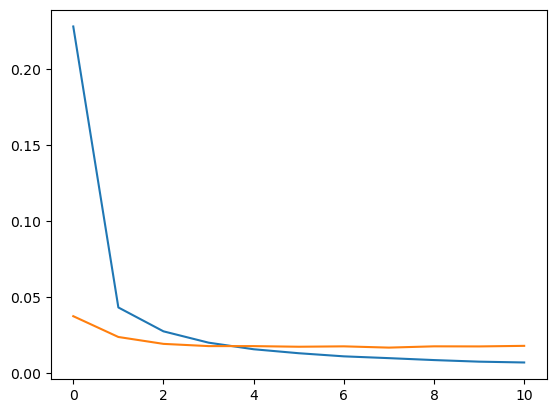

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

In [16]:
def generate(model, tokenizer, dl):

    pred_gens = []
    gens = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dl):
            encoder_strs, proc_batch = process_batch_eval(batch, tokenizer)

            enc_tok_embeds = model.shared(proc_batch['input_ids'])

            encoder_embeds = torch.cat([
                encoder_prefixes.unsqueeze(0).expand(proc_batch['input_ids'].size(0),encoder_prefixes.size(0),768),
                enc_tok_embeds
            ], dim=1)
            attention_mask = torch.cat([
                torch.ones((proc_batch['input_ids'].size(0), encoder_prefixes.size(0))).to(device),
                proc_batch['attention_mask']
            ], dim=1)

            # beam search generations for syntax rather than nucleus sample
            gen = model.generate(
                inputs_embeds=encoder_embeds,
                attention_mask=attention_mask,
                num_beams=5,
                max_new_tokens=100,
            )
            
            gens += [{
                    'prompt': a,
                    'pred': b,
                    'gold': c
                } for a, b, c in zip(encoder_strs, tokenizer.batch_decode(gen, skip_special_tokens=True), batch[2])]
    
    return gens

In [17]:
def process_batch_eval(batch, tokenizer):
    
    labels = [toks.strip().split(' ')[0] for toks in batch[2]]
    encoder_strs = [f'[{b}] {a} <{c}>: ' for a,b,c in zip(batch[0], batch[1], labels)]

    return encoder_strs, tokenizer(encoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)

In [18]:
gens = generate(model, tokenizer, val_dl)

  0%|          | 0/290 [00:00<?, ?it/s]

In [19]:
def matches(y1, y2):
    return ("".join(y1.split()) == "".join(y2.split()))

def exact_match_metric(gens):
    cnt_correct = 0
    errors = []
    for gen in gens:
        if(matches(gen['gold'], gen['pred'])):
            cnt_correct += 1
        else:
            errors.append(gen)

    return cnt_correct/len(gens), errors

In [20]:
accuracy, errors = exact_match_metric(gens)

In [21]:
json.dump(gens, open('gens.json', 'w'), indent=4)
json.dump(errors, open('errors.json', 'w'), indent=4)

In [22]:
accuracy

0.8854616048317515